In [105]:

!pip3 install torchfusion_utils


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [242]:

from PIL import Image
from torchfusion_utils.fp16 import convertToFP16
from torchfusion_utils.initializers import *
from torchfusion_utils.metrics import Accuracy
from torchfusion_utils.models import load_model,save_model
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.datasets import ImageFolder


In [245]:
transforms_train = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

transforms_test = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

# batch_sizes = 10
test_data_dir = 'E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Test'
train_data_dir = 'E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train'

train_data = ImageFolder(root=train_data_dir, transform=transforms_train)
test_data = ImageFolder(root=test_data_dir, transform=transforms_test)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [246]:
train_data

Dataset ImageFolder
    Number of datapoints: 180
    Root location: E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train
    StandardTransform
Transform: Compose(
               Resize(size=225, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [247]:
test_data

Dataset ImageFolder
    Number of datapoints: 40
    Root location: E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Test
    StandardTransform
Transform: Compose(
               Resize(size=225, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [248]:
class_names = ['Fire', 'Neutral', 'Smoke']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.7804,  ..., -0.4118,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -0.8745,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.5922,  ...,  0.3725,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -0.9373,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

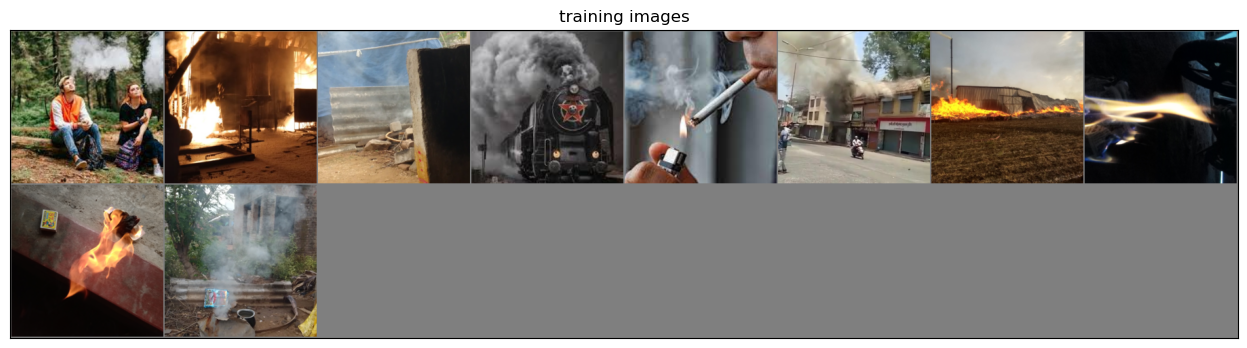

In [249]:
images, labels = next(iter(train_data_loader))

def image_display(image, title="training images"):
    print(image) #values in minus
    image = image/2 + 0.5 #normalizing between 0 to 1
    print(image.min())
    print(image.max())
    numpy_image = image.numpy()
    print(numpy_image.min())
    print(numpy_image.max())
    print("numpy image", numpy_image)
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0)) #if didnt transposed, Invalid shape (3, 454, 1810) for image data
    print("transposed numpy image", transposed_numpy_image)
    print(transposed_numpy_image.min())
    print(transposed_numpy_image.max())
    plt.figure(figsize=(20, 4))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show
    
image_display(torchvision.utils.make_grid(images))

In [250]:
ResNet = models.resnet50(num_classes = 3)


In [251]:
Model = ResNet
Model = Model.to(device)
learning_rate = 0.001
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=learning_rate)
#Converting a model to use float16 instead of float32 can decrease the model size (up to half) and improve performance on some GPUs.
Model, optimizer = convertToFP16(model=Model, optimizer=optimizer)
#The torch.optim.lr_scheduler.MultiStepLR class implements a learning rate scheduler that decays the 
#learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.
milestones = [1, 5, 10, 20, 30, 40]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma = 0.1)

1 / 200 Training loss: 0.0003783173031277127, Tran_Accuracy: 1.0, Validation_loss: 0.0003543078899383545, Validation_Accuracy: 1.0
2 / 200 Training loss: 0.0003873639636569553, Tran_Accuracy: 1.0, Validation_loss: 0.0003543049097061157, Validation_Accuracy: 1.0
3 / 200 Training loss: 0.0003833373387654622, Tran_Accuracy: 1.0, Validation_loss: 0.0003542572259902954, Validation_Accuracy: 1.0
4 / 200 Training loss: 0.00040466255611843534, Tran_Accuracy: 1.0, Validation_loss: 0.00035440027713775637, Validation_Accuracy: 1.0
5 / 200 Training loss: 0.0003880129920111762, Tran_Accuracy: 1.0, Validation_loss: 0.0003543436527252197, Validation_Accuracy: 1.0
6 / 200 Training loss: 0.0003542767630683051, Tran_Accuracy: 1.0, Validation_loss: 0.0003543943166732788, Validation_Accuracy: 1.0
7 / 200 Training loss: 0.0003742906782362196, Tran_Accuracy: 1.0, Validation_loss: 0.0003543108701705933, Validation_Accuracy: 1.0
8 / 200 Training loss: 0.0003675752215915256, Tran_Accuracy: 1.0, Validation_loss

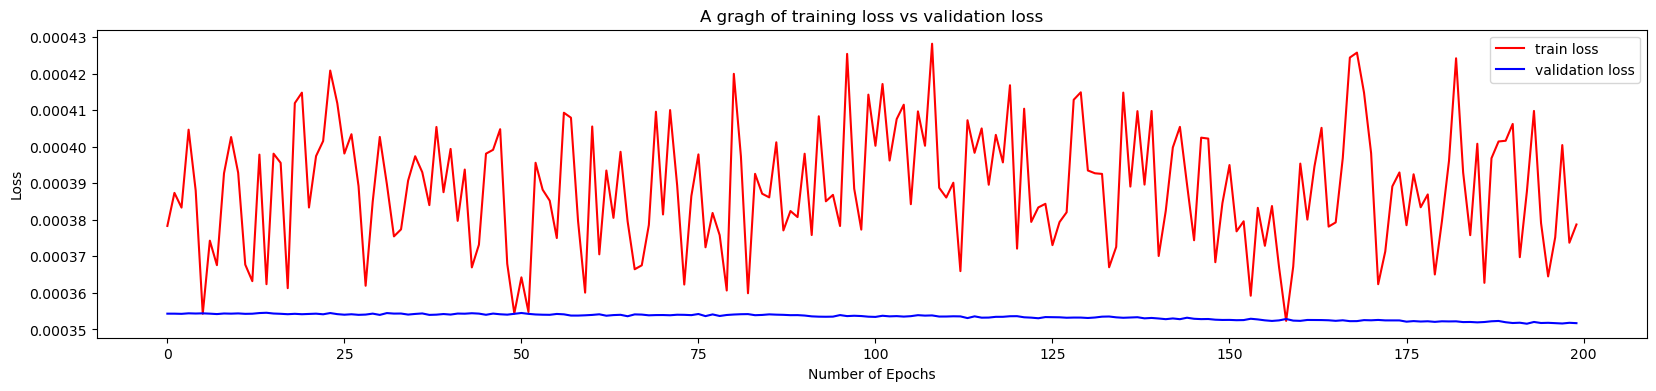

In [280]:
def model_traing_and_validation_loop(Model, n_epochs, save_path):
    
    n_epochs = n_epochs

    #General approach to save best model during training is to monitor the 
    #validation loss at each epoch and save the model if val loss decreases than previous minimum.
    saving_criteria_of_model = 0

    training_loss_array = []

    validation_loss_array = []
    
    train_acc = Accuracy()
    
    validation_acc = Accuracy(topK=1)

    for i in range(n_epochs):

        # print("--------------------Epoch ", i+1, "--------------------")

        total_test_data = 0

        total_train_data = 0

        # correct_test_data = 0

        training_loss = 0

        validation_loss = 0
        
        train_acc.reset()

        for train_batch_idx, (data, target) in enumerate(train_data_loader):

            # print("train loader: Batch index ", train_batch_idx)
            # print("data.size(0)", data.size(0))

            data, target = data.to(device), target.to(device)

            #target = 0,0,0,0,0

            # print("data", data.shape)
            # print(target, "target")
            
            optimizer.zero_grad()

            predictions = Model(data) #not normalized

            # print("predictions", predictions.min())
            # print("predictions", predictions.max())

            loss = Loss(predictions, target)
            
            optimizer.backward(loss)

            optimizer.step()

            training_loss += loss.item()*data.size(0)  #to understand

            train_acc.update(predictions, target) #to understand
            
        scheduler.step()

        # This is useful for inference, when you are sure you will not call tensor.backward(). It will reduce memory consumption for computations
        with torch.no_grad():
            
            validation_acc.reset()
            
            for test_batch_idx, (data, target) in enumerate(test_data_loader):

                # print("test loader: Batch index ", test_batch_idx)

                data, target = data.to(device), target.to(device)
                # print("validation data", data)
                # print("validation target", target)
                predictions = Model(data)
                
                loss = Loss(predictions, target)
                
                validation_acc.update(predictions, target) #to understand
                
                total_test_data += target.size(0) #to understand

                validation_loss += loss.item()*data.size(0) #to understand
                
                
        training_loss = training_loss / len(train_data)
        
        validation_loss = validation_loss / total_test_data

        training_loss_array.append(training_loss)
        
        validation_loss_array.append(validation_loss)


        print(f'{i+1} / {n_epochs} Training loss: {training_loss}, Tran_Accuracy: {train_acc.getValue()}, Validation_loss: {validation_loss}, Validation_Accuracy: {validation_acc.getValue()}')

        # if saving_criteria_of_model < validation_acc.getValue():

    torch.save(Model, save_path)
            
            # saving_criteria_of_model = validation_acc.getValue()
            
    print('--------------------------Saving Model---------------------------')
         
        
    plt.figure(figsize=(20, 4))
        
    x_axis = (range(n_epochs))
        
    plt.plot(x_axis, training_loss_array, 'r', validation_loss_array, 'b')
        
    plt.title('A gragh of training loss vs validation loss')
        
    plt.legend(['train loss', 'validation loss'])
        
    plt.xlabel('Number of Epochs')
        
    plt.ylabel('Loss')
        
    return Model


n_epochs = 200
model = model_traing_and_validation_loop(Model, n_epochs, 'E:/Smoke/fire-flame.pt')

In [281]:

load_saved_model = torch.load('fire-flame.pt')

In [282]:
import glob, cv2

transformer = transforms.Compose([transforms.Resize(225),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5, 0.5, 0.5],
                                        [0.5, 0.5, 0.5])])
for img_path in glob.glob('E:/Smoke/smoke1.jpg'):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img.astype('uint8'))
  orig = img.copy()
  img_processed = transformer(img).unsqueeze(0)
  img_var = Variable(img_processed, requires_grad= False)
  img_var = img_var.cuda()
  load_saved_model.eval()
  logp = load_saved_model(img_var)
  expp = torch.softmax(logp, dim=1)
  confidence, clas = expp.topk(1, dim=1)

  co = confidence.item() * 100

  print("clas", clas)


  class_no = str(clas).split(',')[0]
  class_no = class_no.split('(')
  class_no = class_no[1].rstrip(']]')
  class_no = class_no.lstrip('[[')


  orig = np.array(orig)
  orig = cv2.cvtColor(orig,cv2.COLOR_BGR2RGB)
  orig = cv2.resize(orig,(800,500))

  if class_no == '0':
    print("entered 0")

    label = "Fire: " + str(co)+"%"
    cv2.putText(orig, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

  elif class_no == '1':
    print("entered 1")
    label = "Neutral: " + str(co)+"%"
    cv2.putText(orig, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

  elif class_no =='2':
    print("entered 2")

    label = "Smoke: " + str(co)+"%"
    cv2.putText(orig, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)



  cv2.imwrite("E:/Smoke/Results/{}".format(img_path.split("/")[-1]), orig)

clas tensor([[0]], device='cuda:0')
entered 0


In [283]:
dummy_input = torch.FloatTensor(1,3,224,224)
dummy_input = dummy_input.to(device)

In [284]:
# torch.onnx.export(load_saved_model, dummy_input, 'fire-flame.onnx')

In [285]:
img_path = 'E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train/Train/images (47).jpg'

In [286]:
class_names = ['Fire', 'Neutral','Smoke']


def inferenceing_function(img_path):
    def image_display(img_path):
        
        plt.figure(figsize=(30, 6))
        plt.imshow(Image.open(img_path))
        plt.yticks([])
        plt.xticks([])
        
        plt.show()
        return 'Image of:'
    
    def model_inference_results(img_path):

        transformer = transforms.Compose([transforms.Resize(225),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5],
                                                          [0.5, 0.5, 0.5])])
        img = Image.open(img_path)
        img_processed = transformer(img).unsqueeze(0)
        img_var = Variable(img_processed, requires_grad= False)
        img_var = img_var.cuda()
        load_saved_model.eval()
        logp = load_saved_model(img_var)
        expp = torch.softmax(logp, dim=1)
        confidence, clas = expp.topk(1, dim=1) 
        print(clas)
        
        return f'Class: {class_names[clas]}', f'Confidence score: {confidence.item()}'
        
    
    
    return (image_display(img_path), *model_inference_results(img_path))

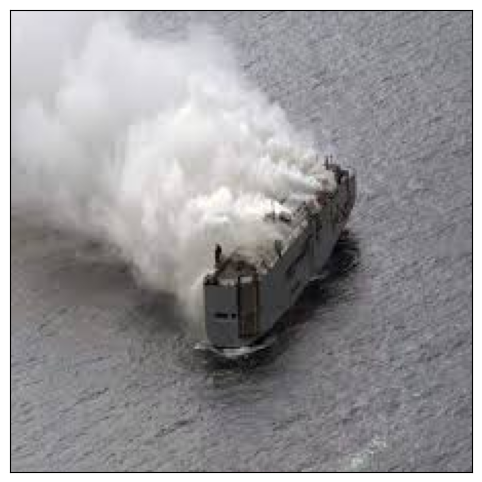

tensor([[0]], device='cuda:0')


('Image of:', 'Class: Fire', 'Confidence score: 1.0')

In [291]:
inferenceing_function(img_path=img_path)